In [1]:
# Import GBApy
#import gba

import os
import sys
import gba

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Create a non full column rank model

To create a non full-column-rank toy model, use the script `./scripts/generate_toy_model.py` (see Github project note).

E.g. here, I used equal kcat values:

```bash
python ./scripts/generate_toy_model.py -path ./toy_models -name efm2 -efms 2 -kcat 10 -gradient 0.0
```

# 2. Load the model + basic manipulations

## 2.1. Load the model

In [2]:
model = gba.read_csv_model("efm2", "../toy_models")
model.summary()

❯ Info,KM backward constants not loaded.


❯ Info,KA constants not loaded.


❯ Info,KI constants not loaded.


❯ Info,Constant RHS terms not loaded.


❯ Info,Constant reactions not loaded.


❯ Info,Protein contributions not loaded.


❯ Info,LP solution not loaded.


Category,Count
Nb metabolites,6
Nb external metabolites,2
Nb internal metabolites,4
Category,Count
Nb reactions,5
Nb exchange reactions,2
Nb internal reactions,2
Category,Count
Column rank,4
Is full column rank?,False


Note that the model is not full column rank (table "Matrix rank").

In [3]:
model.kcat_f

array([10.  , 10.  , 10.  , 10.  ,  4.55])

For this model, the $k_\text{cat}$ value of the reaction `rxn1` (10 h<sup>-1</sup>) is slightly higher than for `rxn2` (9.99 h<sup>-1</sup>). We can expect both EFMs to have very close optimal growth rates.

## 2.2. Explore the fitness landscape of the model

We will now vary the flux of the reaction `rxn2` between 0.0 and 1.0.
As `rxn1` and `rxn2` are transporters, their `f` value will always vary between 0 and 1 thanks to the normalization of mass conservation.
By doing so, we can vizualise the fitness landscape of a flux depending on `rxn2`.

In the example below, for each new value of `rxn2`, the steps are:
- to clear the list of constant reactions,
- to set up the constant value of `rxn2`,
- to find an initial solution given this value,
- to set the initial point $f_0$,
- to run the gradient ascent.

The trick here to avoid very long solving times is to set up the maximal time of the gradient ascent to a small value (here, `max_time = 10`). For this duration, I expect the trajectory to have reached the top of the solution space, where most of the constraints appear.

<strong>WARNING:</strong> For some reasons, the gradient ascent does not work for values close to 0.0 or 1.0. Here, `rxn2` ranges from 0.1 to 0.9.

In [4]:
res   = pd.DataFrame()
label = 1
model.clear_all_trajectories()
for rxn2 in np.arange(0.05, 1.0, 0.05):
    model.clear_constant_reactions()
    model.add_constant_reaction("rxn2", rxn2)
    model.solve_local_linear_problem()
    model.set_f0(model.LP_solution)
    model.gradient_ascent(label=label, condition_id="1", max_time=10, track=True, variables=["f", "v", "p", "b", "c"])
    # Get the last line of model.GA_tracker
    res = pd.concat([res, model.GA_tracker.iloc[-1:]])
    label += 1
res

,label,condition,iter,dt,t,mu,fixed,f_rxn1,f_rxn2,f_rxn3,...,p_rxn4,p_Ribosome,b_C1,b_C2,b_AA,b_Protein,c_C1,c_C2,c_AA,c_Protein
263,1,1,275,0.0,0.920397,0.612173,263,0.95,0.05,0.934902,...,1.791105,58.94549,0.015098,0.003464,0.06103,0.920409,5.133172,1.17763,20.750045,312.939152
523,2,1,271,0.0,0.976001,0.611144,259,0.9,0.1,0.885321,...,3.164101,58.812525,0.014679,0.004893,0.060939,0.919489,4.990929,1.663643,20.719197,312.62623
780,3,1,260,0.000064,1.019584,0.610459,256,0.85,0.15,0.835745,...,4.45708,58.724224,0.014255,0.005989,0.060879,0.918877,4.846865,2.036091,20.698698,312.418346
1034,4,1,254,0.008,1.024,0.60996,253,0.8,0.2,0.786177,...,5.708497,58.659825,0.013823,0.006911,0.060835,0.918431,4.69971,2.349855,20.683741,312.266694
1286,5,1,256,0.000013,1.000013,0.609584,251,0.75,0.25,0.736621,...,6.933411,58.611394,0.013379,0.007724,0.060801,0.918096,4.548696,2.626191,20.672489,312.152624
1536,6,1,250,0.008,0.992,0.609301,249,0.7,0.3,0.687079,...,8.139645,58.574965,0.012921,0.008459,0.060777,0.917844,4.393165,2.876002,20.664023,312.06681
1784,7,1,256,0.0,0.952,0.609094,247,0.65,0.35,0.637552,...,9.331928,58.548289,0.012448,0.009135,0.060758,0.917659,4.232448,3.105767,20.657823,312.003962
2030,8,1,246,0.008,0.96,0.608952,245,0.6,0.4,0.588042,...,10.51341,58.530015,0.011958,0.009764,0.060746,0.917532,4.065803,3.319715,20.653574,311.960908
2276,9,1,250,0.000013,0.944333,0.608869,245,0.55,0.45,0.538552,...,11.68635,58.519337,0.011448,0.010355,0.060739,0.917458,3.892374,3.520785,20.651092,311.935749
2521,10,1,255,0.0,0.912003,0.608841,244,0.5,0.5,0.489085,...,12.852464,58.515823,0.010915,0.010915,0.060736,0.917434,3.711128,3.711128,20.650275,311.927469


We can vizualize a beautiful fitness landscape with two optima.

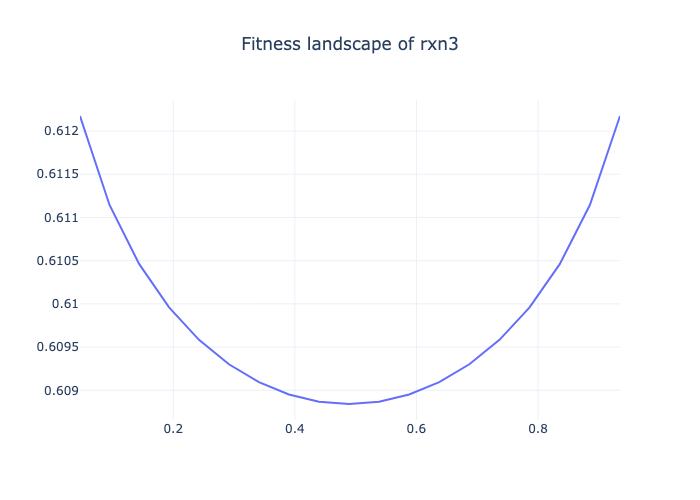

In [5]:
fig = model.create_figure("Fitness landscape of rxn3")
model.add_trajectory(fig, source="data", x_var="f_rxn3", y_var="mu", name="Fitness landscape of rxn3", data=res)
fig.show("png")